# K-Means Clustering Analysis

Load data that was saved at the end of the preprocess step

In [190]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import json
import os

root_path = 'data/'

import pickle
df = pickle.load(open(f'{root_path}/df_covid.p', 'rb'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             187 non-null    object
 1   doi                  171 non-null    object
 2   abstract             187 non-null    object
 3   body_text            187 non-null    object
 4   authors              187 non-null    object
 5   title                187 non-null    object
 6   journal              106 non-null    object
 7   abstract_summary     187 non-null    object
 8   publish_time         187 non-null    object
 9   abstract_word_count  187 non-null    int64 
 10  body_word_count      187 non-null    int64 
 11  body_unique_words    187 non-null    int64 
 12  language             187 non-null    object
 13  processed_text       187 non-null    object
dtypes: int64(3), object(11)
memory usage: 21.9+ KB


In [191]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import json
import os

root_path = 'data/'

import pickle
df = pickle.load(open(f'{root_path}/df_covid.p', 'rb'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             187 non-null    object
 1   doi                  171 non-null    object
 2   abstract             187 non-null    object
 3   body_text            187 non-null    object
 4   authors              187 non-null    object
 5   title                187 non-null    object
 6   journal              106 non-null    object
 7   abstract_summary     187 non-null    object
 8   publish_time         187 non-null    object
 9   abstract_word_count  187 non-null    int64 
 10  body_word_count      187 non-null    int64 
 11  body_unique_words    187 non-null    int64 
 12  language             187 non-null    object
 13  processed_text       187 non-null    object
dtypes: int64(3), object(11)
memory usage: 21.9+ KB


## Word counts in documents

Looking at the number of words in the body text. 

count      187.000000
mean      4284.000000
std       3555.592781
min        476.000000
25%       2209.500000
50%       3458.000000
75%       5002.000000
max      31265.000000
Name: body_word_count, dtype: float64

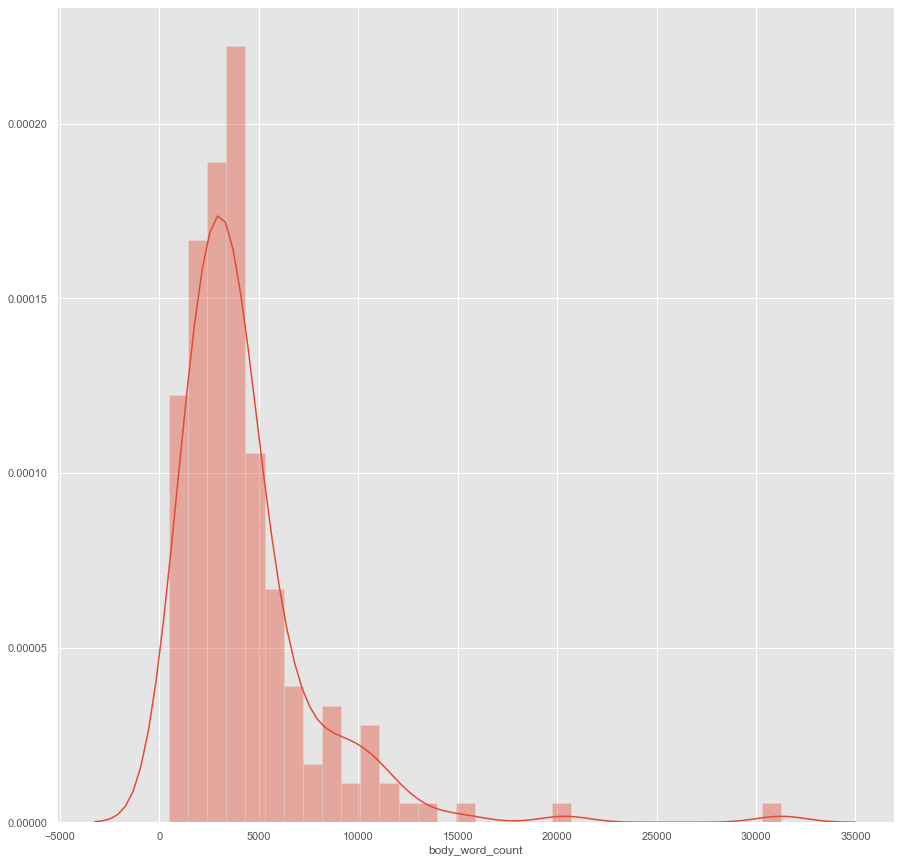

In [192]:
import seaborn as sns
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

Number of unique words in the body text

count     187.00000
mean     1377.84492
std       852.17857
min       275.00000
25%       869.00000
50%      1167.00000
75%      1585.50000
max      6602.00000
Name: body_unique_words, dtype: float64

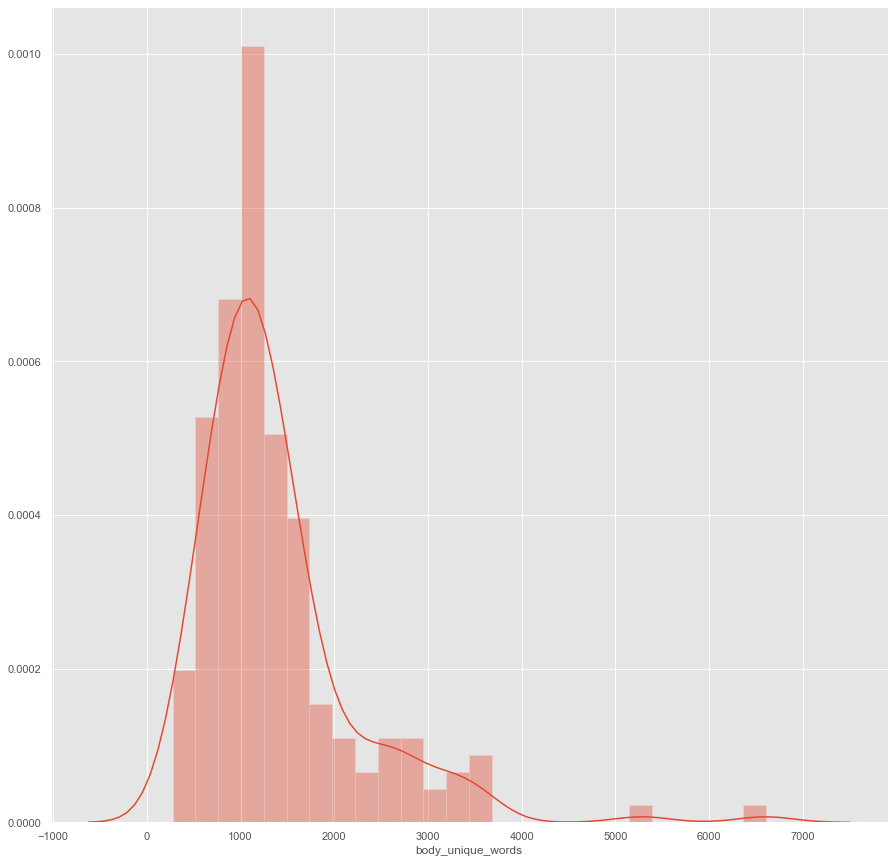

In [193]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

## Vectorization

Calculate the tf-idf vectorization of documents

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [195]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(187, 4096)

## PCA 

Use PCA to reduce the dimension

In [196]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(187, 152)

## K Means Clustering

First figure out the number of clusters

In [197]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

Plot and find the elbow point

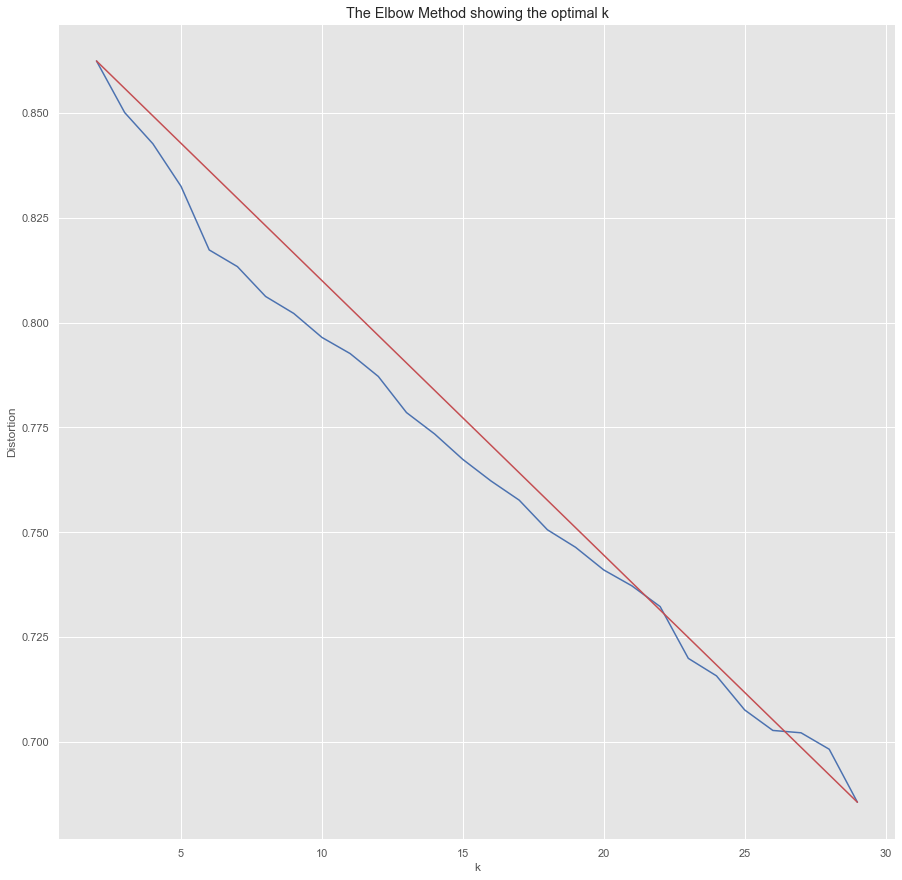

In [198]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the plot, we can see that the elbow point falls at around 6.

Run k-means with the optimal k=6

In [199]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

## Visualizing the clusters

Using t-SNE, reduce the data to 2 dimensions to visualize the clusters. 

In [200]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 186 nearest neighbors...
[t-SNE] Indexed 187 samples in 0.001s...
[t-SNE] Computed neighbors for 187 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 187 / 187
[t-SNE] Mean sigma: 0.397451
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.115185
[t-SNE] KL divergence after 1000 iterations: 0.243650


Now plot it. 

Color the clusters

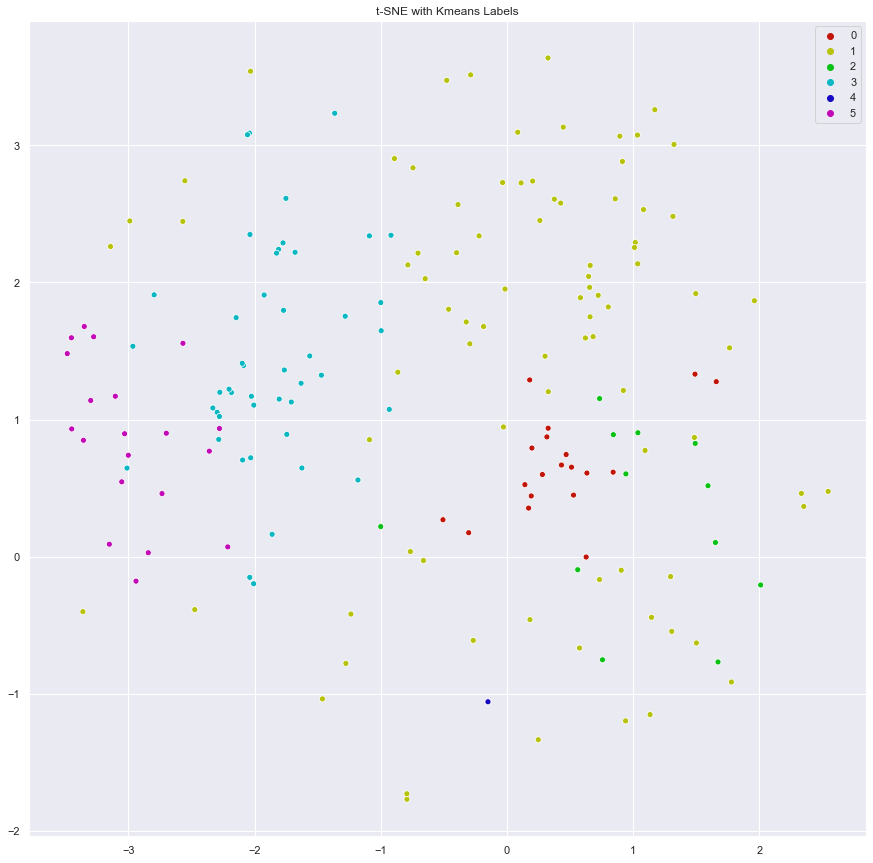

In [201]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

## Topic Modeling

In [202]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
vectorizers = []
for i in range(0, k):
    vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
    vectorizers.append(vectorizer)

Vectorize the data from each cluster

In [203]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 4


### Use LDA to create topics

In [204]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)

Create A LDA model for each cluster. fit_transform all the LDA models on their respective cluster vectors

In [205]:
clusters_lda_data = []

for idx, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))    
    if vectorized_data[idx] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[idx])))

In [206]:
len(lda_models)

6

Extracts the keywords from each cluster

In [207]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1], reverse = True)  
    return_values = [i[0] for i in keywords]
    return return_values

In [208]:
all_keywords = []
for idx, lda in enumerate(lda_models):
    if vectorized_data[idx] != None:
        all_keywords.append(selected_topics(lda, vectorizers[idx]))

## Save Outputs

In [209]:
f = open(f'{root_path}/topics.txt', 'w')
count = 0
for i in all_keywords:
    if vectorized_data[count] == None:
        f.write('Not enough instances to be determined. \n')
    f.write(', '.join(i) + '\n')
    count += 1
f.close()

import pickle
pickle.dump(X_embedded, open(f'{root_path}/X_embedded.p', 'wb'))
pickle.dump(y_pred, open(f'{root_path}/y_pred.p', 'wb'))
